# Library Fundamentals

This notebook introduces the core objects and workflow of **fwd_model_tools** -- a JAX-based library for differentiable forward modeling of cosmological structures.

We will cover:
1. Generating Gaussian initial conditions
2. Running first-order LPT to displace particles
3. Understanding the `ParticleField` coordinate systems
4. Painting particles onto 3D, flat-sky, and spherical grids
5. Computing angular power spectra and comparing to theory
6. Saving results to disk with the `Catalog` container

## Setup

Configure JAX memory allocation and import the core library components.

In [1]:
import os
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

import fwd_model_tools as ffi


/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2026-02-12 23:46:41,101:jax._src.xla_bridge:491: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 489, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/j

# Data types 


In the `fwd_model_tools` package there is 4 types of `Field` objects that all subclasses of `AbstractField`:
- `ParticleField`: represents a set of particles with positions of shape (X , Y , Z , 3)
- `DensityField`: represents a 3D density field in a box, with associated cosmological parameters and power spectrum.
- `FlatDensity`: represents a 2D map on the flat sky
- `SphericalDensity`: represents a healpix map on the sphere.

All share common metadata attributes regarding the box geometry, observer position, and output map resolutions. 

## Static attributes (simulation settings)

These are static attibutes related to the simulation settings which are 

- `mesh_size: tuple[int, int, int]` : The shape of the 3D grid for density fields, or the number of particles along each axis for particle fields.
- `box_size: tuple[float, float, float]` : The physical size of the simulation box along each axis, in comoving Mpc/h.
- `observer_position: tuple[float, float, float]` : The position of the observer within the simulation box, normalized to the box size.

For example if `observer_position=(0.5, 0.5, 0.5)`, the observer is at the center of the box. If `observer_position=(0, 0, 0)`, the observer is at the corner of the box.

## Static attrubutes related to geometry of the output map

- `nside: Optional[int]` : The nside parameter for HEALPix maps, which determines the resolution of spherical density fields. Only relevant for `SphericalDensity` fields.
- `flatsky_npix: Optional[tuple[int, int]]` : The number of pixels along each axis for flat-sky density fields. Only relevant for `FlatDensity` fields.
- `field_size: Optional[float]` : The physical size of the output field in comoving Mpc/h. Only relevant for `FlatDensity` fields.

These are used when painting particles onto a grid to determine the pixelization and resolution of the output density field.
they can be `None` if you are not using that type of field. For example, a `FlatDensity` field would have `nside=None` and a `SphericalDensity` field would have `flatsky_npix=None` and `field_size=None`.

## Units

Units represent the physical units of the field values. 
For positions it is a `ffi.Unit.PositionUnit` which can be `MPC_H` (comoving Mpc/h), `GRID_RELATIVE` (relative to the box size, i.e. between 0 and 1), or `GRID_ABSOLUTE` (absolute grid units, i.e. between 0 and mesh_size).

`GRID_RELATIVE` is very usefull and usually the default since it is the most simple to use in a distributed setup ..
It is basically the relative distance (the total displacement) that the particle did with respect to it's original position assumed to be a uniform grid

## Dynamic attributes (traced by JAX)

Attrubutes related to the particle position which is dynamic and set by the package after a simulation step. These are traced by JAX and can be used in differentiable computations.

- z_sources: Optional[Any] : The redshifts of the sources
- scale_factors: Optional[Any] :  The scale factors corresponding to the redshifts of the sources
- comoving_centers: Optional[Any] : The comoving coordinates of the centers of the pixels in the output density field, used for painting particles onto the grid.
- density_width: Optional[Any] :  The width of the density field in comoving Mpc/h, used for painting particles onto the grid.

The user is not supposed to set these directly, but they can read them and use them in painting of for computation.

They are set automatically after an `lpt` or `nbody` step by the package.
for more info checkout @CLAUDE: link LPT and PM notebooks here

## Sharding 

Sharding information are used to specify how the data is distributed across devices in a multi-device setup. This is important for performance and memory management when running simulations on large datasets.

 - `sharding: Optional[Any] :` A jax sharding object that specifies how the data is distributed across devices. This can be set by the user to control the distribution of data in a multi-device setup
 - `halo_size: tuple[int, int] :` The size of the halo region for distributed computations, specified in grid units. This is used to determine how much overlap is needed between neighboring shards when performing operations that require information from adjacent grid cells, such as painting particles onto a grid or computing density fields.

For more info on sharding and halo exchange checkout @CLAUDE: link to sharding and halo exchange notebook here

## Batching


Any object can be batched (by having a leading axis) but only one leading axis is allowed.
And generally speaking, we enforce that the dynamic metadata have the same leading axis as the particle positions. This is to ensure that the metadata is correctly associated with the corresponding particles when performing operations on batches of data.


# Running a simple Lagrangian Perturbation Theory (LPT) simulation

## Creating Initial Conditions

`gaussian_initial_conditions` generates a 3D Gaussian random field whose covariance matches the linear matter power spectrum $P(k)$. The returned `DensityField` carries all metadata needed by downstream functions: box geometry, observer position, and output map resolutions.


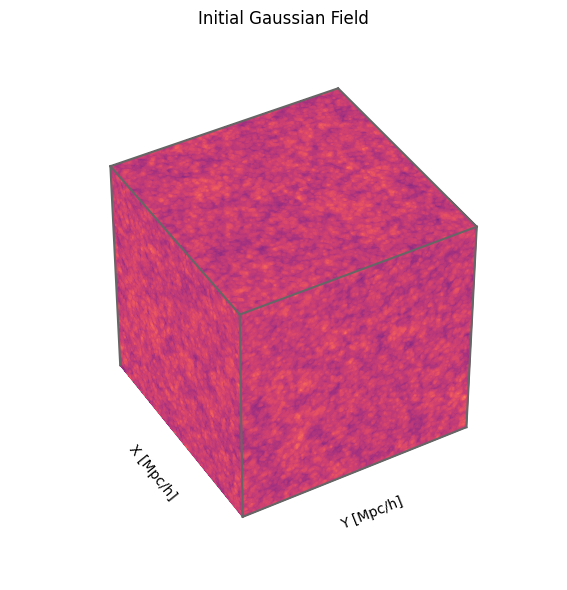

In [2]:
key = jax.random.PRNGKey(42)
mesh_size = (128, 128, 128)
box_size = (500.0, 500.0, 500.0)
nside = 128
flatsky_npix = (128, 128)
field_size = (10, 10)
cosmo = ffi.Planck18()

initial_field = ffi.gaussian_initial_conditions(
    key, mesh_size, box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
)

initial_field.show(
    labels=["X [Mpc/h]", "Y [Mpc/h]", ""],
    colorbar=False,
    titles=["Initial Gaussian Field"],
)

## Running LPT at a Single Scale Factor

First-order LPT (the Zel'dovich approximation) displaces particles from their Lagrangian grid positions **q** to Eulerian positions:

$$\mathbf{x}(a) = \mathbf{q} + D(a)\,\boldsymbol{\Psi}(\mathbf{q})$$

When `scale_factor_spec` is a **scalar**, `lpt` returns `ParticleField` objects for displacements and momenta at that single time. No lightcone shells are created -- the output represents the full 3D particle distribution at one epoch.

In [3]:
dx, p = ffi.lpt(cosmo, initial_field, scale_factor_spec=0.5, order=1)

print(f"Displacement field type: {type(dx).__name__}")
print(f"Displacement unit: {dx.unit}")
print(f"Array shape: {dx.array.shape}")

Displacement field type: ParticleField
Displacement unit: PositionUnit.GRID_RELATIVE
Array shape: (128, 128, 128, 3)


## ParticleField Coordinate Systems

`ParticleField` tracks particle positions in three coordinate systems, accessible via `.to(unit)`:

| Unit | Meaning | Range |
|------|---------|-------|
| `GRID_RELATIVE` | Displacements from the uniform Lagrangian grid | unbounded very close to zero |
| `GRID_ABSOLUTE` | Absolute grid indices | [0, N_mesh) |
| `MPC_H` | Physical comoving coordinates | [0, box_size) Mpc/h |

The conversion is lossless and preserves all metadata. Painting functions interpret positions differently depending on the unit.

__note__: Any object can be plotted and in here we use thinning to reduce the number of particles for visualization purposes.

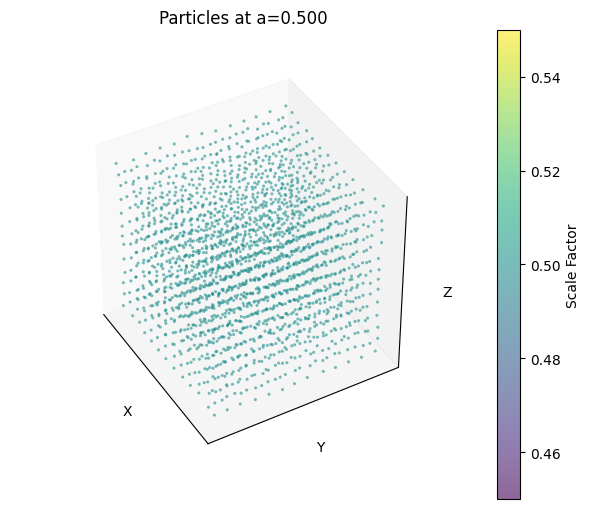

In [4]:
dx.to(ffi.PositionUnit.GRID_ABSOLUTE).show(thinning=10, weights="a")

## Painting Targets

Particles can be deposited onto three different grid geometries:

| Target | Method | Output Type | Use Case |
|--------|--------|-------------|----------|
| **3D density** | `.paint()` | `DensityField` | Volume analysis, 3D power spectra |
| **Flat 2D** | `.paint_2d(center, width)` | `FlatDensity` | Small-angle surveys, flat-sky C_ell |
| **Spherical** | `.paint_spherical(center, width)` | `SphericalDensity` | Full-sky maps, HEALPix C_ell |

All painting uses Cloud-in-Cell (CIC) interpolation for the Cartesian grids, and configurable schemes for HEALPix.

### Paint to 3D Density

3D density shape: (128, 128, 128)


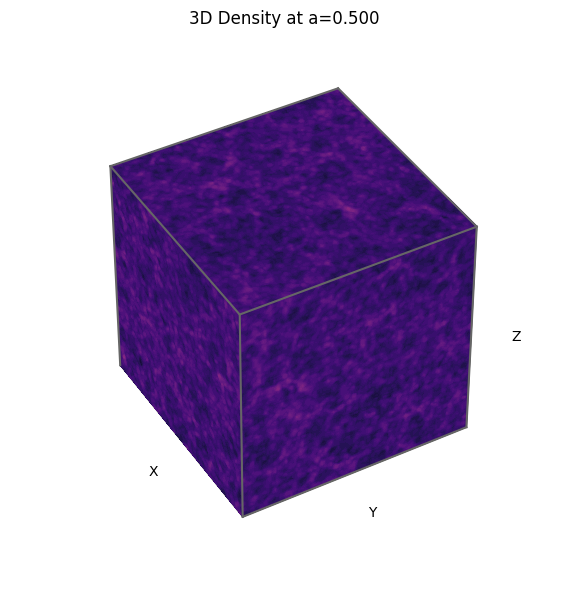

In [5]:
density_3d = dx.to(ffi.PositionUnit.GRID_ABSOLUTE).paint()
print(f"3D density shape: {density_3d.array.shape}")
density_3d.apply_fn(jnp.log1p).show(colorbar=False, project_slices=32)

### Paint to Flat 2D

Flat-sky painting requires a `center` (comoving distance to the shell center) and `density_plane_width` (shell thickness). For a single scalar scale factor, we use the maximum comoving radius as center and a nominal width.

self.array sharding: GSPMDSharding({replicated}, memory_kind=device)
self.array sharding after cast: GSPMDSharding({replicated}, memory_kind=device)
data sharding before map: GSPMDSharding({replicated}, memory_kind=device)
positions sharding: GSPMDSharding({replicated}, memory_kind=device)
xy sharding: GSPMDSharding({replicated}, memory_kind=device)
dz sharding: GSPMDSharding({replicated}, memory_kind=device)
Flat map shape: (128, 128)


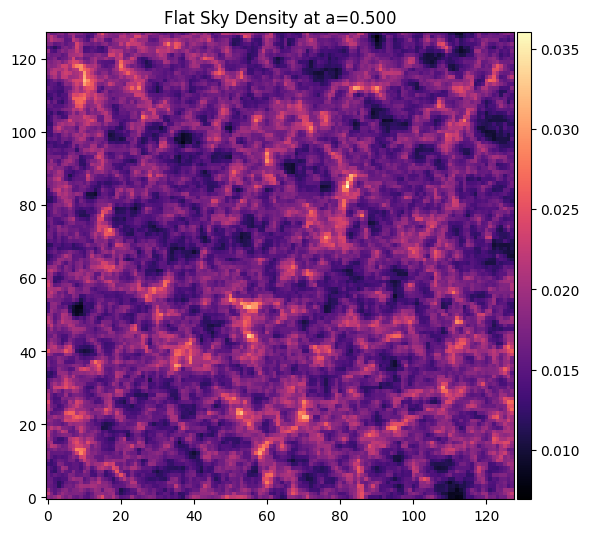

In [6]:
r_max = initial_field.max_comoving_radius

flat_map = dx.paint_2d(
    center=r_max / 2,
    density_plane_width=r_max,
)
print(f"Flat map shape: {flat_map.array.shape}")
flat_map.show()

### Paint to Spherical (HEALPix)

Spherical painting projects particles onto HEALPix maps using one of three interpolation schemes:
- `"ngp"` -- Nearest Grid Point: fastest, assigns each particle to a single pixel
- `"bilinear"` -- Bilinear interpolation over neighboring pixels (default)
- `"rbf_neighbor"` -- RBF kernel smoothing over neighbors

Spherical map shape: (196608,), nside=128


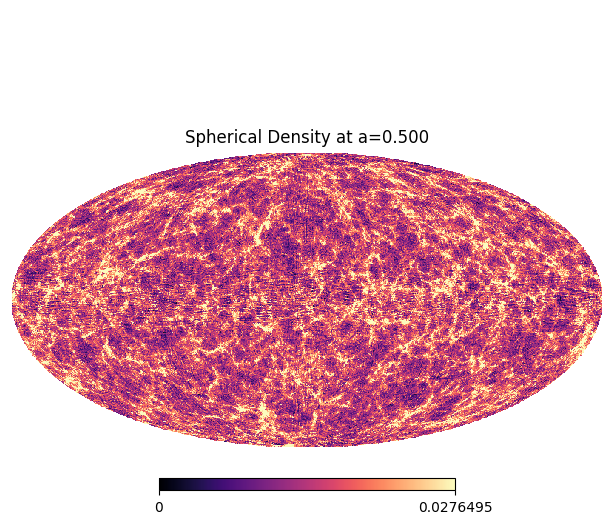

In [7]:
spherical_map = dx.to(ffi.PositionUnit.GRID_ABSOLUTE).paint_spherical(
    center=r_max / 2,
    density_plane_width=r_max,
    scheme="bilinear",
)
print(f"Spherical map shape: {spherical_map.array.shape}, nside={spherical_map.nside}")
spherical_map.show()

## Power Spectra

Angular power spectra $C_\ell$ quantify the amplitude of fluctuations at each angular scale $\ell$. Both `FlatDensity` and `SphericalDensity` provide `.angular_cl()` methods. We can compare measured spectra against the linear theory prediction computed by `compute_theory_cl`.

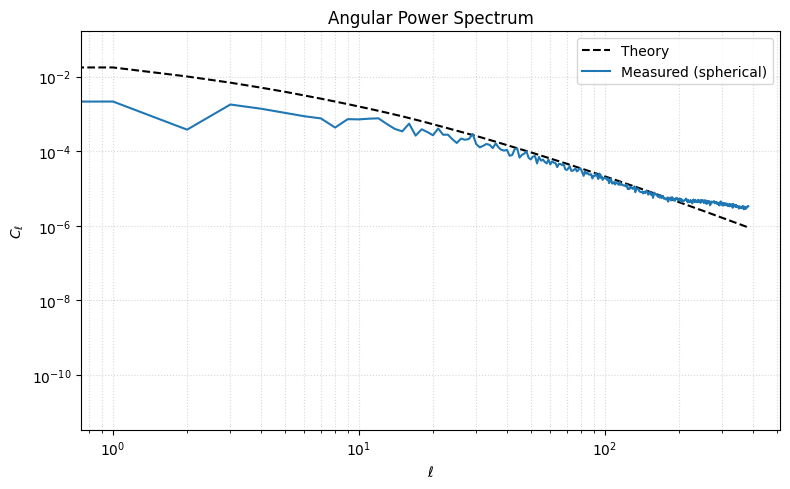

In [8]:
# Measured angular power spectrum
cl_measured = spherical_map.to(ffi.units.OVERDENSITY).angular_cl(method="healpy")

# Theory prediction
LMAX = 3 * nside - 1
ells = jnp.arange(LMAX)
max_a = jc.background.a_of_chi(cosmo , spherical_map.max_comoving_radius)
max_z = jc.utils.a2z(max_a)

nz_source = [ffi.tophat_z(0.0, max_z, gals_per_arcmin2=1.0)]
theory_cl = ffi.compute_theory_cl(
    cosmo, ell=ells, z_source=nz_source,
    probe_type="number_counts", nonlinear_fn="linear", cross=False,
)

fig, ax = plt.subplots(figsize=(8, 5))
theory_cl.plot(ax=ax, logx=True, logy=True, label="Theory", color="black", linestyle="--")
cl_measured.plot(ax=ax, logx=True, logy=True, label="Measured (spherical)")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$C_\ell$")
ax.set_title("Angular Power Spectrum")
ax.legend()
plt.tight_layout()
plt.show()

## Saving Results

The `Catalog` container bundles a field with its cosmology for serialization. It supports:
- **Parquet**: `catalog.to_parquet(path)` / `Catalog.from_parquet(path)`
- **HuggingFace Datasets**: `catalog.to_dataset()` for sharing on the Hub

Both formats preserve all field metadata (mesh size, box size, units, scale factors, etc.).

__note__: Make sure to install `fwd_model_tools[catalog]` to use the `Catalog` functionality.

> *Important* : The catalog enforces having non-empty dynamic metadata for the field,

In [22]:
# Build a Catalog from the spherical density and cosmology
catalog = ffi.io.Catalog(field=ffi.SphericalDensity.stack([spherical_map , spherical_map * 2]), cosmology=cosmo)
print(catalog)

Catalog(
  field     =SphericalDensity(array  = Array(2, 196608)
, dtype  = float64,   mesh_size         =(128, 128, 128),   box_size          =(500.0, 500.0, 500.0),   observer_position =(0.5, 0.5, 0.5),   sharding          =None,   halo_size         =(0, 0),   nside             =128,   flatsky_npix      =(128, 128),   field_size        =(10, 10),   status            =LIGHTCONE,   unit              =DENSITY),
  cosmology =Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102 
    Omega_nu: 0.0,   version   =2)


To save to parquet you can just call `catalog.to_parquet("output.parquet")` and to load it back you can call `Catalog.from_parquet("output.parquet")`. This is very useful for sharing results and for checkpointing during long simulations.

In [23]:
# Save to parquet (requires pip install fwd-model-tools[catalog])
catalog.to_parquet("output_basics.parquet")

reloaded = ffi.io.Catalog.from_parquet("output_basics.parquet")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [75]:
sph = ffi.SphericalDensity.stack([spherical_map , spherical_map * 2])

sph = ffi.SphericalDensity.stack([sph , sph * 2])
sph.shape

(2, 2, 196608)

In [80]:
sph = ffi.SphericalDensity.stack([sph , sph * 2])
sph.shape

(2, 2, 2, 2, 2, 2, 2, 196608)

In [64]:
import equinox as eqx

eqx.tree_equal(catalog.field, rel.field , typematch=False, atol=1e-6, rtol=1e-6)

False

In [69]:
def error(tree1, tree2):
    return jax.tree.reduce(lambda x, y: x + y, jax.tree_util.tree_map(lambda x, y: jnp.max((x - y) ** 2), tree1, tree2))

rel = dataclasses.replace(reloaded[0], version=catalog.version * 1.0)
mse(catalog, rel)

Array(5.10725766e-19, dtype=float64)

In [45]:
import dataclasses
dataclasses.replace(reloaded[0], version=2)

Catalog(
  field     =SphericalDensity(array  = Array(2, 196608)
, dtype  = float32,   mesh_size         =(128, 128, 128),   box_size          =(500.0, 500.0, 500.0),   observer_position =(0.5, 0.5, 0.5),   sharding          =None,   halo_size         =(0.0, 0.0),   nside             =128,   flatsky_npix      =(128, 128),   field_size        =(10.0, 10.0),   status            =LIGHTCONE,   unit              =DENSITY),
  cosmology =Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102 
    Omega_nu: 0.0,   version   =2)

In [27]:
catalog

Catalog(
  field     =SphericalDensity(array  = Array(2, 196608)
, dtype  = float64,   mesh_size         =(128, 128, 128),   box_size          =(500.0, 500.0, 500.0),   observer_position =(0.5, 0.5, 0.5),   sharding          =None,   halo_size         =(0, 0),   nside             =128,   flatsky_npix      =(128, 128),   field_size        =(10, 10),   status            =LIGHTCONE,   unit              =DENSITY),
  cosmology =Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102 
    Omega_nu: 0.0,   version   =2)

# Creating a hugging face dataset from a catalog

You can convert a `Catalog` to a HuggingFace Dataset using `catalog.to_dataset()`. This allows you to easily share your results on the HuggingFace Hub or use the rich ecosystem of tools for analysis and visualization.

In [11]:
# Convert to HuggingFace Dataset
ds = catalog.to_dataset()
print(ds)


Dataset({
    features: ['array', 'z_sources', 'scale_factors', 'comoving_centers', 'density_width', 'mesh_size', 'box_size', 'observer_position', 'halo_size', 'status', 'unit', 'field_type', 'version', 'nside', 'flatsky_npix', 'field_size', 'Omega_c', 'Omega_b', 'h', 'n_s', 'sigma8', 'w0', 'wa', 'Omega_k', 'Omega_nu'],
    num_rows: 1
})


In [12]:
# Can also convert back to Catalog
catalog_from_ds = ffi.io.Catalog.from_dataset(ds)
print(catalog_from_ds)

[Catalog(
  field     =SphericalDensity(array  = Array(196608,)
, dtype  = float32,   mesh_size         =(128, 128, 128),   box_size          =(500.0, 500.0, 500.0),   observer_position =(0.5, 0.5, 0.5),   sharding          =None,   halo_size         =(0.0, 0.0),   nside             =128,   flatsky_npix      =(128, 128),   field_size        =(10.0, 10.0),   status            =LIGHTCONE,   unit              =DENSITY),
  cosmology =Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102 
    Omega_nu: 0.0,   version   =2.0)]


In [18]:
jax.tree.map_with_path(lambda path, x: print(f"{path}: {type(x).__name__}"), catalog)

(GetAttrKey(name='field'), GetAttrKey(name='array')): ArrayImpl
(GetAttrKey(name='field'), GetAttrKey(name='z_sources')): ArrayImpl
(GetAttrKey(name='field'), GetAttrKey(name='scale_factors')): ArrayImpl
(GetAttrKey(name='field'), GetAttrKey(name='comoving_centers')): ArrayImpl
(GetAttrKey(name='field'), GetAttrKey(name='density_width')): ArrayImpl
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=0)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=1)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=2)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=3)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=4)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=5)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=6)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=7)): float
(GetAttrKey(name='cosmology'), FlattenedIndexKey(key=8)): float


AttributeError: 'NoneType' object has no attribute 'shape'

In [13]:
catalog_from_ds.field.show()

AttributeError: 'list' object has no attribute 'field'